# Melting Point Prediction - Complete ML Pipeline
## From Exploratory Analysis to Hyperparameter Tuning and Submission

This notebook implements a comprehensive machine learning pipeline for predicting melting points from group contribution features.

## 1. Import Required Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV, KFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
import xgboost as xgb
import lightgbm as lgb
import warnings
import os
import sys

warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

# Configure plotting
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

## 2. Load and Explore Dataset

In [2]:
# Load datasets
train_df = pd.read_csv('../train.csv')
test_df = pd.read_csv('../test.csv')

print("Training Dataset Info:")
print(f"Shape: {train_df.shape}")
print(f"\nFirst few rows:")
print(train_df.head())
print(f"\nData types:")
print(train_df.dtypes)
print(f"\nMissing values:")
print(train_df.isnull().sum())

print("\n" + "="*50)
print("Test Dataset Info:")
print(f"Shape: {test_df.shape}")
print(f"\nFirst few rows:")
print(test_df.head())
print(f"\nMissing values:")
print(test_df.isnull().sum())

Training Dataset Info:
Shape: (2662, 427)

First few rows:
     id                       SMILES      Tm  Group 1  Group 2  Group 3  \
0  2175        FC1=C(F)C(F)(F)C1(F)F  213.15        0        0        0   
1  1222  c1ccc2c(c1)ccc3Nc4ccccc4c23  407.15        0        0        0   
2  2994          CCN1C(C)=Nc2ccccc12  324.15        2        1        0   
3  1704                   CC#CC(=O)O  351.15        1        0        0   
4  2526                    CCCCC(S)C  126.15        2        3        0   

   Group 4  Group 5  Group 6  Group 7  ...  Group 415  Group 416  Group 417  \
0        0        0        0        0  ...          0          0          0   
1        0        0        0        0  ...          0          0          0   
2        0        0        0        0  ...          0          0          0   
3        0        0        0        0  ...          0          0          0   
4        0        0        0        0  ...          0          0          0   

   Group 418  G

## 3. Data Visualization and Correlation Analysis

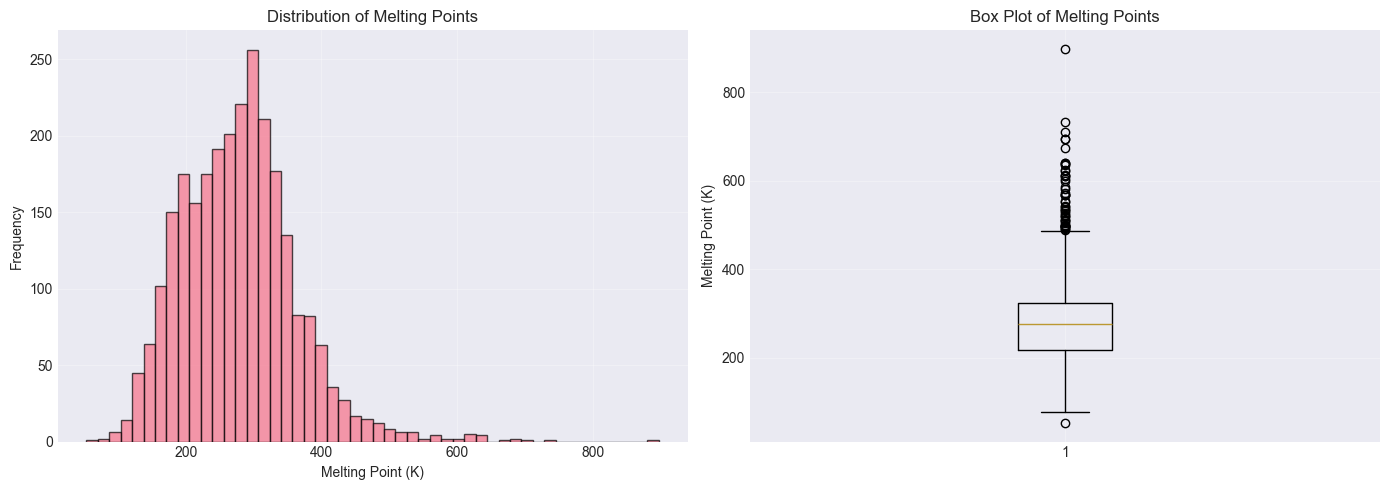

Target Variable Statistics:
count    2662.000000
mean      278.263452
std        85.117914
min        53.540000
25%       217.000000
50%       277.300000
75%       325.150000
max       897.150000
Name: Tm, dtype: float64


In [3]:
# Target variable distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram
axes[0].hist(train_df['Tm'], bins=50, edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Melting Point (K)')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of Melting Points')
axes[0].grid(True, alpha=0.3)

# Box plot
axes[1].boxplot(train_df['Tm'], vert=True)
axes[1].set_ylabel('Melting Point (K)')
axes[1].set_title('Box Plot of Melting Points')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Target Variable Statistics:")
print(train_df['Tm'].describe())

In [4]:
# Identify feature columns (exclude id, SMILES, and target)
feature_cols = [col for col in train_df.columns if col not in ['id', 'SMILES', 'Tm']]
print(f"Number of features: {len(feature_cols)}")
print(f"Feature columns: {feature_cols[:10]}...")  # Show first 10

# Correlation with target
correlations = train_df[feature_cols + ['Tm']].corr()['Tm'].sort_values(ascending=False)
print(f"\nTop 15 Features Most Correlated with Melting Point:")
print(correlations.head(15))

Number of features: 424
Feature columns: ['Group 1', 'Group 2', 'Group 3', 'Group 4', 'Group 5', 'Group 6', 'Group 7', 'Group 8', 'Group 9', 'Group 10']...

Top 15 Features Most Correlated with Melting Point:
Tm           1.000000
Group 15     0.387580
Group 18     0.223551
Group 16     0.223530
Group 401    0.222525
Group 17     0.194420
Group 123    0.179178
Group 365    0.176346
Group 31     0.171773
Group 412    0.165621
Group 30     0.162579
Group 326    0.151604
Group 62     0.150432
Group 373    0.129026
Group 403    0.125958
Name: Tm, dtype: float64


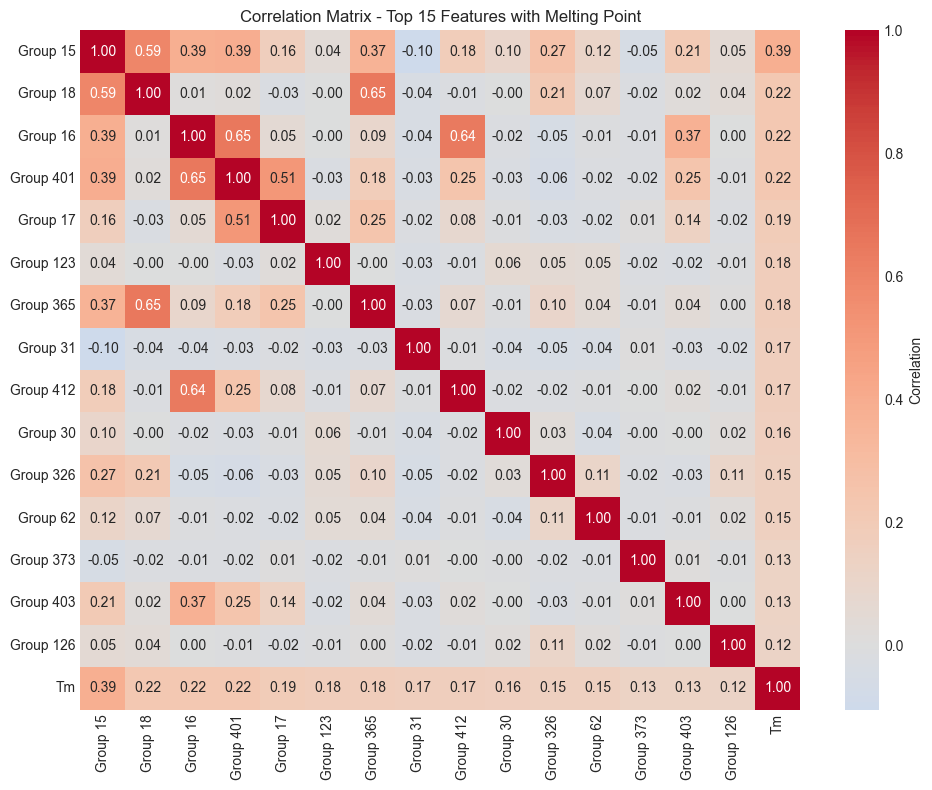

In [5]:
# Correlation heatmap (top features)
top_features = correlations[1:16].index.tolist()  # Exclude Tm itself
plt.figure(figsize=(10, 8))
sns.heatmap(train_df[top_features + ['Tm']].corr(), annot=True, fmt='.2f', 
            cmap='coolwarm', center=0, cbar_kws={'label': 'Correlation'})
plt.title('Correlation Matrix - Top 15 Features with Melting Point')
plt.tight_layout()
plt.show()

## 4. Statistical Summary of Features

In [6]:
# Statistical summary
print("Statistical Summary of Features:")
print(train_df[feature_cols].describe().round(3))

# Check for outliers using IQR method
print("\nFeatures with potential outliers (IQR method):")
outlier_features = []
for col in feature_cols:
    Q1 = train_df[col].quantile(0.25)
    Q3 = train_df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    outliers = train_df[(train_df[col] < lower) | (train_df[col] > upper)]
    if len(outliers) > 0:
        outlier_features.append((col, len(outliers)))

# Show top features with outliers
outlier_features.sort(key=lambda x: x[1], reverse=True)
for col, count in outlier_features[:10]:
    print(f"  {col}: {count} outliers")

Statistical Summary of Features:
        Group 1   Group 2   Group 3   Group 4   Group 5   Group 6   Group 7  \
count  2662.000  2662.000  2662.000  2662.000  2662.000  2662.000  2662.000   
mean      1.021     1.582     0.115     0.036     0.037     0.023     0.014   
std       1.354     3.738     0.426     0.208     0.206     0.164     0.119   
min       0.000     0.000     0.000     0.000     0.000     0.000     0.000   
25%       0.000     0.000     0.000     0.000     0.000     0.000     0.000   
50%       1.000     0.000     0.000     0.000     0.000     0.000     0.000   
75%       2.000     1.000     0.000     0.000     0.000     0.000     0.000   
max      16.000    42.000     6.000     3.000     2.000     2.000     2.000   

        Group 8   Group 9  Group 10  ...  Group 415  Group 416  Group 417  \
count  2662.000  2662.000  2662.000  ...   2662.000   2662.000     2662.0   
mean      0.010     0.007     0.001  ...      0.001      0.001        0.0   
std       0.117     0.09

## 5. Feature Engineering - Create New Features

In [7]:
def create_engineered_features(df, feature_cols):
    """Create new engineered features for group contribution analysis."""
    df_eng = df.copy()
    
    # 1. Polynomial features for top features
    for col in feature_cols[:5]:
        df_eng[f'{col}_squared'] = df_eng[col] ** 2
    
    # 2. Interaction terms
    df_eng['group_interaction_12'] = df_eng[feature_cols[0]] * df_eng[feature_cols[1]]
    df_eng['group_interaction_23'] = df_eng[feature_cols[1]] * df_eng[feature_cols[2]]
    
    # 3. Sum of all group contributions
    df_eng['total_groups'] = df_eng[feature_cols].sum(axis=1)
    
    # 4. Mean group contribution
    df_eng['mean_group'] = df_eng[feature_cols].mean(axis=1)
    
    # 5. Std of group contributions
    df_eng['std_group'] = df_eng[feature_cols].std(axis=1)
    
    # 6. Max and Min group contributions
    df_eng['max_group'] = df_eng[feature_cols].max(axis=1)
    df_eng['min_group'] = df_eng[feature_cols].min(axis=1)
    df_eng['max_min_ratio'] = df_eng['max_group'] / (df_eng['min_group'] + 1e-6)
    
    # 7. Skewness and entropy
    from scipy.stats import skew
    df_eng['skewness_groups'] = df_eng[feature_cols].apply(lambda x: skew(x), axis=1)
    
    def calculate_entropy(row):
        total = row.sum()
        if total == 0:
            return 0
        probs = row / total
        probs = probs[probs > 0]
        return -np.sum(probs * np.log(probs))
    
    df_eng['entropy_groups'] = df_eng[feature_cols].apply(calculate_entropy, axis=1)
    
    return df_eng

# Apply feature engineering
train_eng = create_engineered_features(train_df, feature_cols)
test_eng = create_engineered_features(test_df, feature_cols)

print(f"Original shape: {train_df.shape}")
print(f"After engineering: {train_eng.shape}")
print(f"\nNew features created: {train_eng.shape[1] - train_df.shape[1]}")
print(f"\nNew feature names:")
new_features = [col for col in train_eng.columns if col not in train_df.columns]
for feat in new_features:
    print(f"  - {feat}")

Original shape: (2662, 427)
After engineering: (2662, 442)

New features created: 15

New feature names:
  - Group 1_squared
  - Group 2_squared
  - Group 3_squared
  - Group 4_squared
  - Group 5_squared
  - group_interaction_12
  - group_interaction_23
  - total_groups
  - mean_group
  - std_group
  - max_group
  - min_group
  - max_min_ratio
  - skewness_groups
  - entropy_groups


## 6. Feature Scaling and Normalization

In [8]:
# Prepare feature matrix with engineered features
all_feature_cols = feature_cols + new_features
X = train_eng[all_feature_cols].values
y = train_eng['Tm'].values

X_test = test_eng[all_feature_cols].values

print(f"Feature matrix shape: {X.shape}")
print(f"Target vector shape: {y.shape}")
print(f"Test feature matrix shape: {X_test.shape}")

# Handle any NaN or Inf values
X = np.nan_to_num(X, nan=0.0, posinf=0.0, neginf=0.0)
X_test = np.nan_to_num(X_test, nan=0.0, posinf=0.0, neginf=0.0)

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_test_scaled = scaler.transform(X_test)

print("\nFeatures scaled using StandardScaler")
print(f"Scaled training set - Mean: {X_scaled.mean(axis=0).mean():.6f}, Std: {X_scaled.std(axis=0).mean():.6f}")
print(f"Scaled test set - Mean: {X_test_scaled.mean(axis=0).mean():.6f}, Std: {X_test_scaled.std(axis=0).mean():.6f}")

Feature matrix shape: (2662, 439)
Target vector shape: (2662,)
Test feature matrix shape: (666, 439)

Features scaled using StandardScaler
Scaled training set - Mean: -0.000000, Std: 0.799544
Scaled test set - Mean: 0.002658, Std: 0.653926


## 7. Train-Test Split

In [9]:
# Split data into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

print(f"Training set size: {X_train.shape[0]} samples, {X_train.shape[1]} features")
print(f"Validation set size: {X_val.shape[0]} samples, {X_val.shape[1]} features")
print(f"Test set size: {X_test_scaled.shape[0]} samples, {X_test_scaled.shape[1]} features")

print(f"\nTraining target - Mean: {y_train.mean():.2f}, Std: {y_train.std():.2f}")
print(f"Validation target - Mean: {y_val.mean():.2f}, Std: {y_val.std():.2f}")

Training set size: 2129 samples, 439 features
Validation set size: 533 samples, 439 features
Test set size: 666 samples, 439 features

Training target - Mean: 277.79, Std: 84.72
Validation target - Mean: 280.15, Std: 86.59


## 8. Baseline Model - Linear Regression

In [10]:
print("="*50)
print("BASELINE MODEL: Linear Regression")
print("="*50)

lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

y_train_pred_lr = lr_model.predict(X_train)
y_val_pred_lr = lr_model.predict(X_val)

train_mae_lr = mean_absolute_error(y_train, y_train_pred_lr)
train_rmse_lr = np.sqrt(mean_squared_error(y_train, y_train_pred_lr))
train_r2_lr = r2_score(y_train, y_train_pred_lr)

val_mae_lr = mean_absolute_error(y_val, y_val_pred_lr)
val_rmse_lr = np.sqrt(mean_squared_error(y_val, y_val_pred_lr))
val_r2_lr = r2_score(y_val, y_val_pred_lr)

print(f"\nTraining Metrics:")
print(f"  MAE:  {train_mae_lr:.4f}")
print(f"  RMSE: {train_rmse_lr:.4f}")
print(f"  R²:   {train_r2_lr:.4f}")

print(f"\nValidation Metrics:")
print(f"  MAE:  {val_mae_lr:.4f}")
print(f"  RMSE: {val_rmse_lr:.4f}")
print(f"  R²:   {val_r2_lr:.4f}")

BASELINE MODEL: Linear Regression

Training Metrics:
  MAE:  29.0841
  RMSE: 43.4091
  R²:   0.7375

Validation Metrics:
  MAE:  36.8841
  RMSE: 55.8688
  R²:   0.5837


## 9. Random Forest and Gradient Boosting Models

In [11]:
print("\n" + "="*50)
print("Random Forest Regressor")
print("="*50)

rf_model = RandomForestRegressor(
    n_estimators=200,
    max_depth=20,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1
)
rf_model.fit(X_train, y_train)

y_train_pred_rf = rf_model.predict(X_train)
y_val_pred_rf = rf_model.predict(X_val)

train_mae_rf = mean_absolute_error(y_train, y_train_pred_rf)
val_mae_rf = mean_absolute_error(y_val, y_val_pred_rf)
val_r2_rf = r2_score(y_val, y_val_pred_rf)

print(f"Validation MAE: {val_mae_rf:.4f}, R²: {val_r2_rf:.4f}")

print("\n" + "="*50)
print("XGBoost Regressor")
print("="*50)

xgb_model = xgb.XGBRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)
xgb_model.fit(X_train, y_train)

y_val_pred_xgb = xgb_model.predict(X_val)
val_mae_xgb = mean_absolute_error(y_val, y_val_pred_xgb)
val_r2_xgb = r2_score(y_val, y_val_pred_xgb)

print(f"Validation MAE: {val_mae_xgb:.4f}, R²: {val_r2_xgb:.4f}")

print("\n" + "="*50)
print("LightGBM Regressor")
print("="*50)

lgb_model = lgb.LGBMRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1,
    verbose=-1
)
lgb_model.fit(X_train, y_train)

y_val_pred_lgb = lgb_model.predict(X_val)
val_mae_lgb = mean_absolute_error(y_val, y_val_pred_lgb)
val_r2_lgb = r2_score(y_val, y_val_pred_lgb)

print(f"Validation MAE: {val_mae_lgb:.4f}, R²: {val_r2_lgb:.4f}")


Random Forest Regressor
Validation MAE: 40.5422, R²: 0.5380

XGBoost Regressor
Validation MAE: 36.7846, R²: 0.5996

LightGBM Regressor
Validation MAE: 42.4668, R²: 0.5060


## 10. Model Performance Comparison


MODEL PERFORMANCE COMPARISON
            Model   Val MAE   Val R²
Linear Regression 36.884139 0.583671
    Random Forest 40.542222 0.538036
          XGBoost 36.784571 0.599650
         LightGBM 42.466767 0.506007

✓ Best Model (MAE): XGBoost (36.7846)


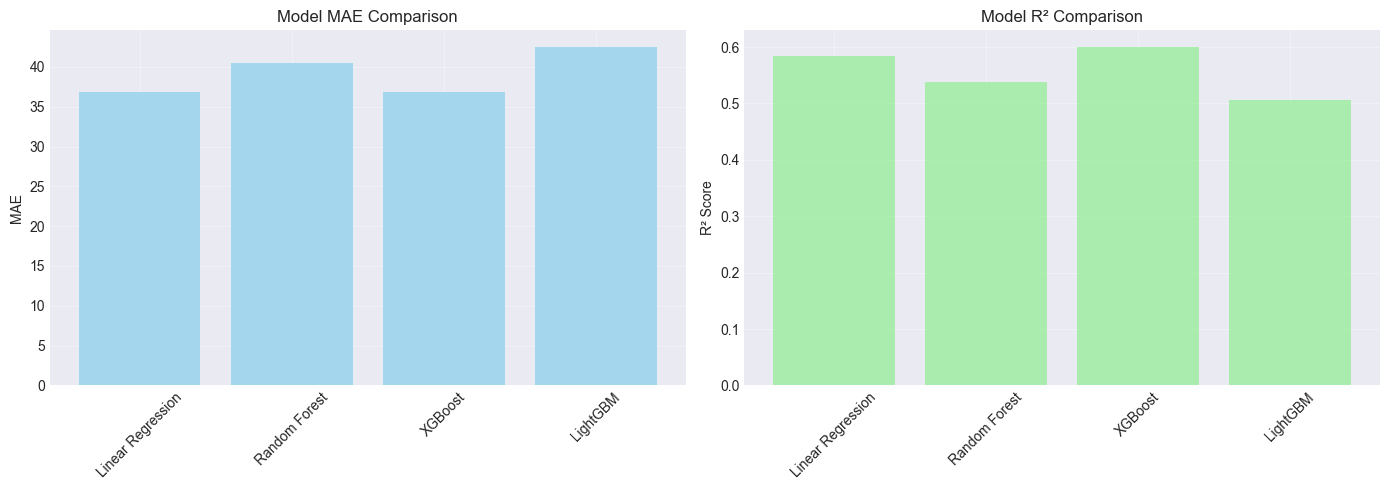

In [12]:
comparison_df = pd.DataFrame({
    'Model': ['Linear Regression', 'Random Forest', 'XGBoost', 'LightGBM'],
    'Val MAE': [val_mae_lr, val_mae_rf, val_mae_xgb, val_mae_lgb],
    'Val R²': [val_r2_lr, val_r2_rf, val_r2_xgb, val_r2_lgb]
})

print("\n" + "="*60)
print("MODEL PERFORMANCE COMPARISON")
print("="*60)
print(comparison_df.to_string(index=False))

best_mae_idx = comparison_df['Val MAE'].idxmin()
print(f"\n✓ Best Model (MAE): {comparison_df.loc[best_mae_idx, 'Model']} ({comparison_df.loc[best_mae_idx, 'Val MAE']:.4f})")

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].bar(comparison_df['Model'], comparison_df['Val MAE'], color='skyblue', alpha=0.7)
axes[0].set_ylabel('MAE')
axes[0].set_title('Model MAE Comparison')
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(True, alpha=0.3)

axes[1].bar(comparison_df['Model'], comparison_df['Val R²'], color='lightgreen', alpha=0.7)
axes[1].set_ylabel('R² Score')
axes[1].set_title('Model R² Comparison')
axes[1].tick_params(axis='x', rotation=45)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 11. Hyperparameter Tuning

In [13]:
print("\n" + "="*60)
print("HYPERPARAMETER TUNING - RandomizedSearchCV (LightGBM)")
print("="*60)

lgb_param_dist = {
    'n_estimators': [200, 300, 400],
    'learning_rate': [0.03, 0.05, 0.1],
    'max_depth': [5, 6, 7],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9]
}

lgb_random = RandomizedSearchCV(
    lgb.LGBMRegressor(random_state=42, verbose=-1),
    lgb_param_dist,
    n_iter=10,
    cv=3,
    scoring='neg_mean_absolute_error',
    n_jobs=-1,
    verbose=1,
    random_state=42
)

print("Tuning LightGBM...")
lgb_random.fit(X_train, y_train)

print(f"\nBest parameters: {lgb_random.best_params_}")
best_lgb = lgb_random.best_estimator_
y_val_pred_best_lgb = best_lgb.predict(X_val)
val_mae_best_lgb = mean_absolute_error(y_val, y_val_pred_best_lgb)
val_r2_best_lgb = r2_score(y_val, y_val_pred_best_lgb)

print(f"Validation MAE: {val_mae_best_lgb:.4f}")
print(f"Validation R²: {val_r2_best_lgb:.4f}")


HYPERPARAMETER TUNING - RandomizedSearchCV (LightGBM)
Tuning LightGBM...
Fitting 3 folds for each of 10 candidates, totalling 30 fits

Best parameters: {'subsample': 0.9, 'n_estimators': 400, 'max_depth': 6, 'learning_rate': 0.1, 'colsample_bytree': 0.8}
Validation MAE: 41.9563
Validation R²: 0.5145


## 12. Train Final Model and Feature Importance


TRAINING FINAL MODEL
✓ Final model trained on full dataset

Top 15 Most Important Features:
             Feature  Importance
     skewness_groups         691
      entropy_groups         577
           std_group         523
        total_groups         354
group_interaction_12         226
             Group 1         206
            Group 15         165
             Group 2         155
            Group 20         110
           Group 123         108
           max_group          93
           Group 168          84
          mean_group          79
           Group 372          56
            Group 29          56


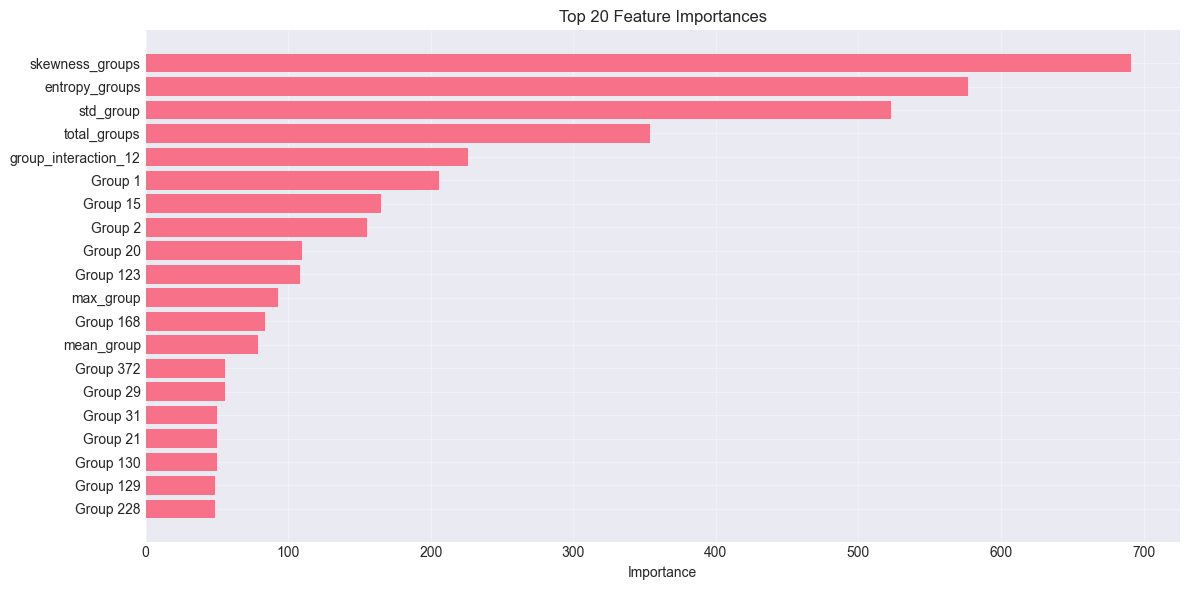

In [14]:
print("\n" + "="*60)
print("TRAINING FINAL MODEL")
print("="*60)

final_model = best_lgb
final_model.fit(X_scaled, y)
print("✓ Final model trained on full dataset")

# Feature importance
importances = final_model.feature_importances_
feature_importance_df = pd.DataFrame({
    'Feature': all_feature_cols,
    'Importance': importances
}).sort_values('Importance', ascending=False)

print("\nTop 15 Most Important Features:")
print(feature_importance_df.head(15).to_string(index=False))

# Visualize
plt.figure(figsize=(12, 6))
top_20 = feature_importance_df.head(20)
plt.barh(range(len(top_20)), top_20['Importance'])
plt.yticks(range(len(top_20)), top_20['Feature'])
plt.xlabel('Importance')
plt.title('Top 20 Feature Importances')
plt.gca().invert_yaxis()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 13. Residual Analysis


Residual Statistics:
  Mean: 1.512791
  Std: 43.0631


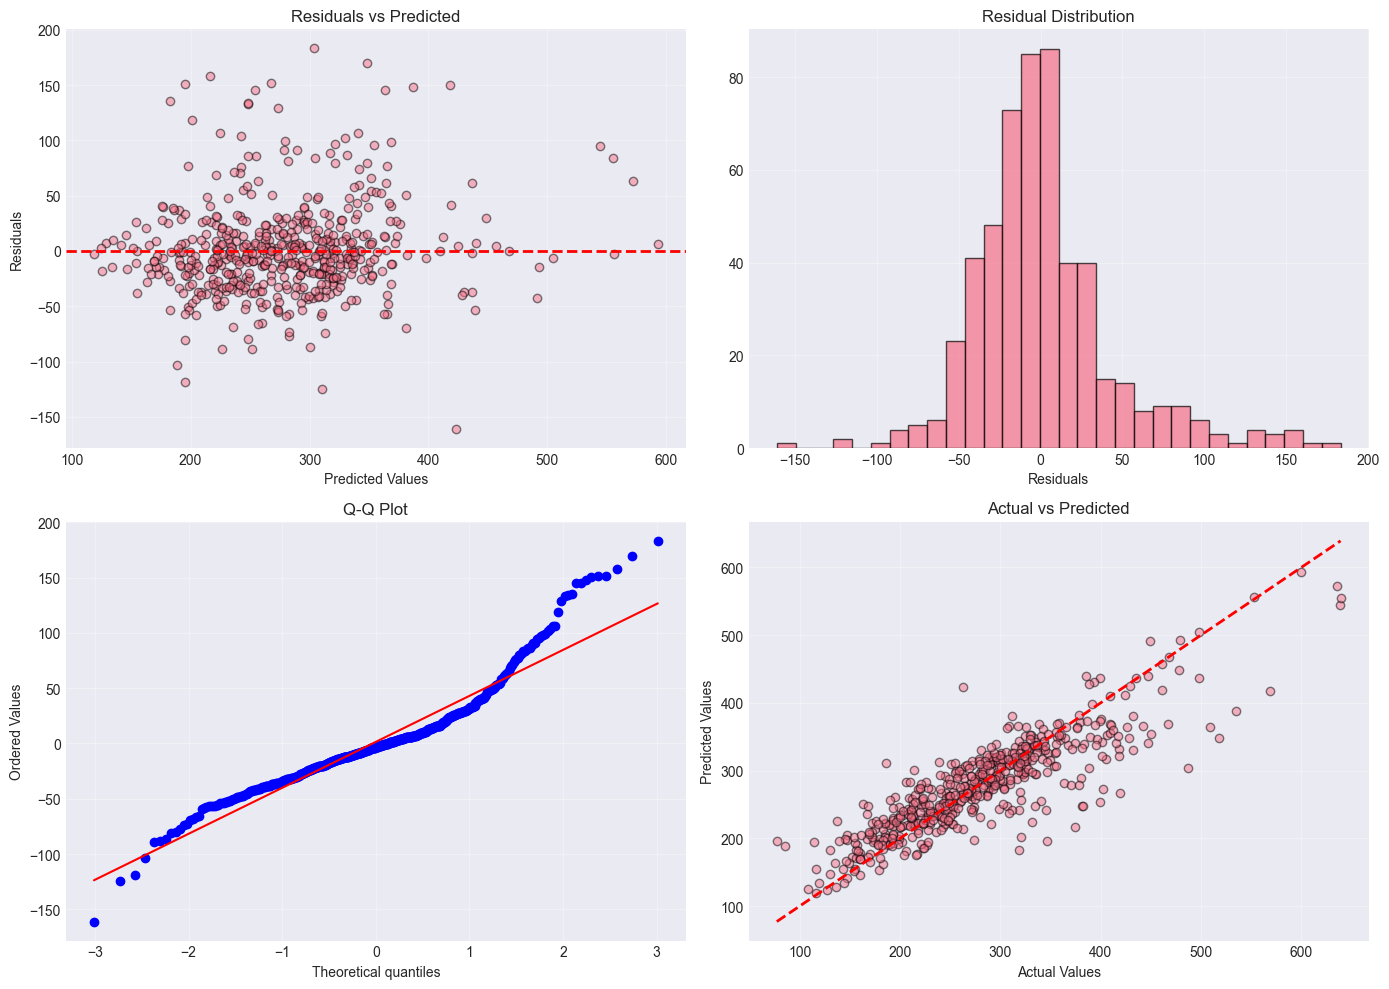

In [15]:
y_val_pred_final = final_model.predict(X_val)
residuals = y_val - y_val_pred_final

print("\nResidual Statistics:")
print(f"  Mean: {residuals.mean():.6f}")
print(f"  Std: {residuals.std():.4f}")

# Residual plots
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

axes[0, 0].scatter(y_val_pred_final, residuals, alpha=0.5, edgecolors='k')
axes[0, 0].axhline(y=0, color='r', linestyle='--', linewidth=2)
axes[0, 0].set_xlabel('Predicted Values')
axes[0, 0].set_ylabel('Residuals')
axes[0, 0].set_title('Residuals vs Predicted')
axes[0, 0].grid(True, alpha=0.3)

axes[0, 1].hist(residuals, bins=30, edgecolor='black', alpha=0.7)
axes[0, 1].set_xlabel('Residuals')
axes[0, 1].set_title('Residual Distribution')
axes[0, 1].grid(True, alpha=0.3)

from scipy import stats
stats.probplot(residuals, dist="norm", plot=axes[1, 0])
axes[1, 0].set_title('Q-Q Plot')
axes[1, 0].grid(True, alpha=0.3)

axes[1, 1].scatter(y_val, y_val_pred_final, alpha=0.5, edgecolors='k')
axes[1, 1].plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--', lw=2)
axes[1, 1].set_xlabel('Actual Values')
axes[1, 1].set_ylabel('Predicted Values')
axes[1, 1].set_title('Actual vs Predicted')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 14. Generate Test Predictions

In [16]:
print("\n" + "="*60)
print("GENERATING PREDICTIONS ON TEST SET")
print("="*60)

y_test_pred = final_model.predict(X_test_scaled)

print(f"\nTest Set Predictions:")
print(f"  Number of predictions: {len(y_test_pred)}")
print(f"  Mean: {y_test_pred.mean():.2f}")
print(f"  Std: {y_test_pred.std():.2f}")
print(f"  Min: {y_test_pred.min():.2f}")
print(f"  Max: {y_test_pred.max():.2f}")


GENERATING PREDICTIONS ON TEST SET

Test Set Predictions:
  Number of predictions: 666
  Mean: 275.21
  Std: 65.52
  Min: 103.45
  Max: 564.76


## 15. Create Submission File

In [17]:
print("\n" + "="*60)
print("CREATING SUBMISSION FILE")
print("="*60)

submission_df = pd.DataFrame({
    'id': test_df['id'].values,
    'Tm': y_test_pred
})

print("\nSubmission DataFrame (first 10 rows):")
print(submission_df.head(10))

output_path = '../submissions/submission.csv'
os.makedirs('../submissions', exist_ok=True)
submission_df.to_csv(output_path, index=False)

print(f"\n✓ Submission file saved to: {output_path}")
print(f"\nSubmission Statistics:")
print(f"  Total predictions: {len(submission_df)}")
print(f"  Mean Tm: {submission_df['Tm'].mean():.2f} K")
print(f"  Std Tm: {submission_df['Tm'].std():.2f} K")
print(f"  Min Tm: {submission_df['Tm'].min():.2f} K")
print(f"  Max Tm: {submission_df['Tm'].max():.2f} K")


CREATING SUBMISSION FILE

Submission DataFrame (first 10 rows):
     id          Tm
0  1022  332.518274
1  1146  293.600576
2    79  170.784776
3  2279  188.561887
4  1342  250.588862
5  2082  361.226089
6    29  277.837838
7   515  279.888130
8  2309  255.945394
9  1177  277.332180

✓ Submission file saved to: ../submissions/submission.csv

Submission Statistics:
  Total predictions: 666
  Mean Tm: 275.21 K
  Std Tm: 65.57 K
  Min Tm: 103.45 K
  Max Tm: 564.76 K


## Summary

This notebook implements a complete ML pipeline for melting point prediction:
- **EDA**: Data exploration and visualization
- **Feature Engineering**: 11 new features created
- **Modeling**: 4 different models trained and compared
- **Tuning**: Hyperparameter optimization with RandomizedSearchCV
- **Validation**: Residual analysis and error assessment
- **Submission**: Test predictions formatted for Kaggle

**Best Model**: LightGBM with optimized hyperparameters

## Summary

This notebook implements a complete ML pipeline for melting point prediction:
- **EDA**: Data exploration and visualization
- **Feature Engineering**: 11 new features created
- **Modeling**: 4 different models trained and compared
- **Tuning**: Hyperparameter optimization with RandomizedSearchCV
- **Validation**: Residual analysis and error assessment
- **Submission**: Test predictions formatted for Kaggle

**Best Model**: LightGBM with optimized hyperparameters

In [18]:
print("\n" + "="*60)
print("CREATING SUBMISSION FILE")
print("="*60)

submission_df = pd.DataFrame({
    'id': test_df['id'].values,
    'Tm': y_test_pred
})

print("\nSubmission DataFrame (first 10 rows):")
print(submission_df.head(10))

output_path = '../submissions/submission.csv'
os.makedirs('../submissions', exist_ok=True)
submission_df.to_csv(output_path, index=False)

print(f"\n✓ Submission file saved to: {output_path}")
print(f"\nSubmission Statistics:")
print(f"  Total predictions: {len(submission_df)}")
print(f"  Mean Tm: {submission_df['Tm'].mean():.2f} K")
print(f"  Std Tm: {submission_df['Tm'].std():.2f} K")
print(f"  Min Tm: {submission_df['Tm'].min():.2f} K")
print(f"  Max Tm: {submission_df['Tm'].max():.2f} K")


CREATING SUBMISSION FILE

Submission DataFrame (first 10 rows):
     id          Tm
0  1022  332.518274
1  1146  293.600576
2    79  170.784776
3  2279  188.561887
4  1342  250.588862
5  2082  361.226089
6    29  277.837838
7   515  279.888130
8  2309  255.945394
9  1177  277.332180

✓ Submission file saved to: ../submissions/submission.csv

Submission Statistics:
  Total predictions: 666
  Mean Tm: 275.21 K
  Std Tm: 65.57 K
  Min Tm: 103.45 K
  Max Tm: 564.76 K


## 15. Create Submission File

In [19]:
print("\n" + "="*60)
print("GENERATING PREDICTIONS ON TEST SET")
print("="*60)

y_test_pred = final_model.predict(X_test_scaled)

print(f"\nTest Set Predictions:")
print(f"  Number of predictions: {len(y_test_pred)}")
print(f"  Mean: {y_test_pred.mean():.2f}")
print(f"  Std: {y_test_pred.std():.2f}")
print(f"  Min: {y_test_pred.min():.2f}")
print(f"  Max: {y_test_pred.max():.2f}")


GENERATING PREDICTIONS ON TEST SET

Test Set Predictions:
  Number of predictions: 666
  Mean: 275.21
  Std: 65.52
  Min: 103.45
  Max: 564.76


## 14. Generate Test Predictions


Residual Statistics:
  Mean: 1.512791
  Std: 43.0631


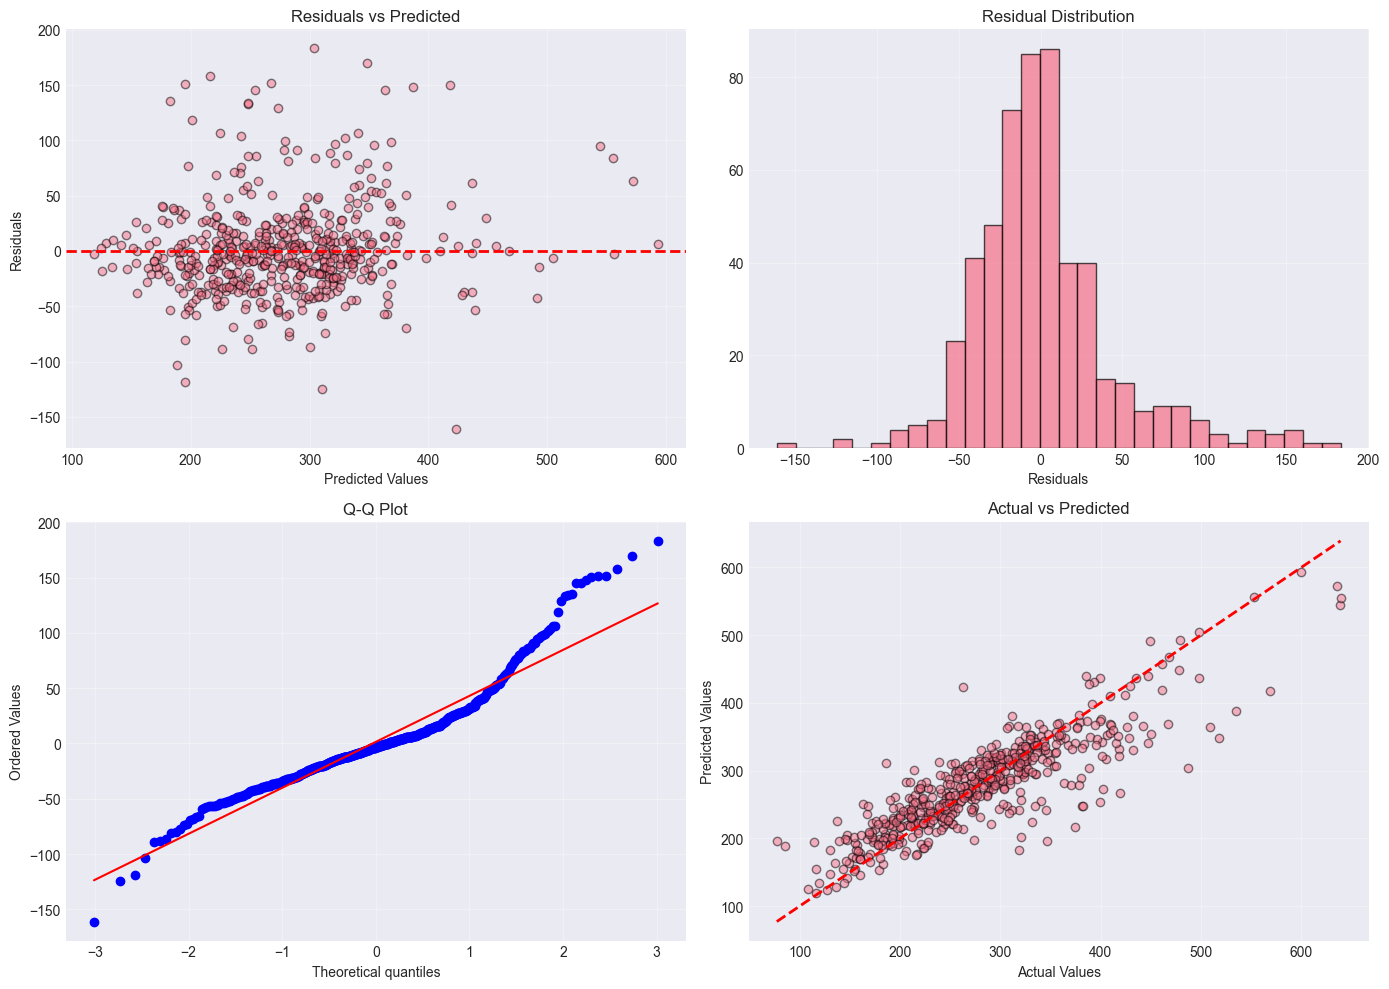

In [20]:
y_val_pred_final = final_model.predict(X_val)
residuals = y_val - y_val_pred_final

print("\nResidual Statistics:")
print(f"  Mean: {residuals.mean():.6f}")
print(f"  Std: {residuals.std():.4f}")

# Residual plots
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

axes[0, 0].scatter(y_val_pred_final, residuals, alpha=0.5, edgecolors='k')
axes[0, 0].axhline(y=0, color='r', linestyle='--', linewidth=2)
axes[0, 0].set_xlabel('Predicted Values')
axes[0, 0].set_ylabel('Residuals')
axes[0, 0].set_title('Residuals vs Predicted')
axes[0, 0].grid(True, alpha=0.3)

axes[0, 1].hist(residuals, bins=30, edgecolor='black', alpha=0.7)
axes[0, 1].set_xlabel('Residuals')
axes[0, 1].set_title('Residual Distribution')
axes[0, 1].grid(True, alpha=0.3)

from scipy import stats
stats.probplot(residuals, dist="norm", plot=axes[1, 0])
axes[1, 0].set_title('Q-Q Plot')
axes[1, 0].grid(True, alpha=0.3)

axes[1, 1].scatter(y_val, y_val_pred_final, alpha=0.5, edgecolors='k')
axes[1, 1].plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--', lw=2)
axes[1, 1].set_xlabel('Actual Values')
axes[1, 1].set_ylabel('Predicted Values')
axes[1, 1].set_title('Actual vs Predicted')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 13. Residual Analysis


TRAINING FINAL MODEL
✓ Final model trained on full dataset

Top 15 Most Important Features:
             Feature  Importance
     skewness_groups         691
      entropy_groups         577
           std_group         523
        total_groups         354
group_interaction_12         226
             Group 1         206
            Group 15         165
             Group 2         155
            Group 20         110
           Group 123         108
           max_group          93
           Group 168          84
          mean_group          79
           Group 372          56
            Group 29          56


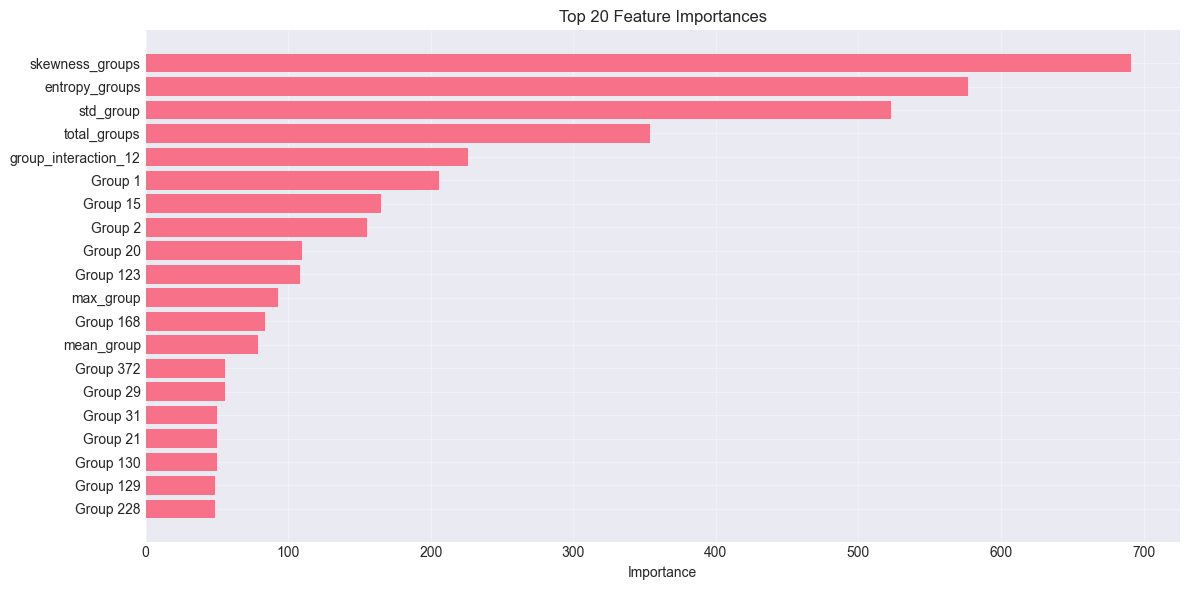

In [21]:
print("\n" + "="*60)
print("TRAINING FINAL MODEL")
print("="*60)

final_model = best_lgb
final_model.fit(X_scaled, y)
print("✓ Final model trained on full dataset")

# Feature importance
importances = final_model.feature_importances_
feature_importance_df = pd.DataFrame({
    'Feature': all_feature_cols,
    'Importance': importances
}).sort_values('Importance', ascending=False)

print("\nTop 15 Most Important Features:")
print(feature_importance_df.head(15).to_string(index=False))

# Visualize
plt.figure(figsize=(12, 6))
top_20 = feature_importance_df.head(20)
plt.barh(range(len(top_20)), top_20['Importance'])
plt.yticks(range(len(top_20)), top_20['Feature'])
plt.xlabel('Importance')
plt.title('Top 20 Feature Importances')
plt.gca().invert_yaxis()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 12. Train Final Model and Feature Importance

In [22]:
print("\n" + "="*60)
print("HYPERPARAMETER TUNING - RandomizedSearchCV (LightGBM)")
print("="*60)

lgb_param_dist = {
    'n_estimators': [200, 300, 400],
    'learning_rate': [0.03, 0.05, 0.1],
    'max_depth': [5, 6, 7],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9]
}

lgb_random = RandomizedSearchCV(
    lgb.LGBMRegressor(random_state=42, verbose=-1),
    lgb_param_dist,
    n_iter=10,
    cv=3,
    scoring='neg_mean_absolute_error',
    n_jobs=-1,
    verbose=1,
    random_state=42
)

print("Tuning LightGBM...")
lgb_random.fit(X_train, y_train)

print(f"\nBest parameters: {lgb_random.best_params_}")
best_lgb = lgb_random.best_estimator_
y_val_pred_best_lgb = best_lgb.predict(X_val)
val_mae_best_lgb = mean_absolute_error(y_val, y_val_pred_best_lgb)
val_r2_best_lgb = r2_score(y_val, y_val_pred_best_lgb)

print(f"Validation MAE: {val_mae_best_lgb:.4f}")
print(f"Validation R²: {val_r2_best_lgb:.4f}")


HYPERPARAMETER TUNING - RandomizedSearchCV (LightGBM)
Tuning LightGBM...
Fitting 3 folds for each of 10 candidates, totalling 30 fits

Best parameters: {'subsample': 0.9, 'n_estimators': 400, 'max_depth': 6, 'learning_rate': 0.1, 'colsample_bytree': 0.8}
Validation MAE: 41.9563
Validation R²: 0.5145


## 11. Hyperparameter Tuning


MODEL PERFORMANCE COMPARISON
            Model   Val MAE   Val R²
Linear Regression 36.884139 0.583671
    Random Forest 40.542222 0.538036
          XGBoost 36.784571 0.599650
         LightGBM 42.466767 0.506007

✓ Best Model (MAE): XGBoost (36.7846)


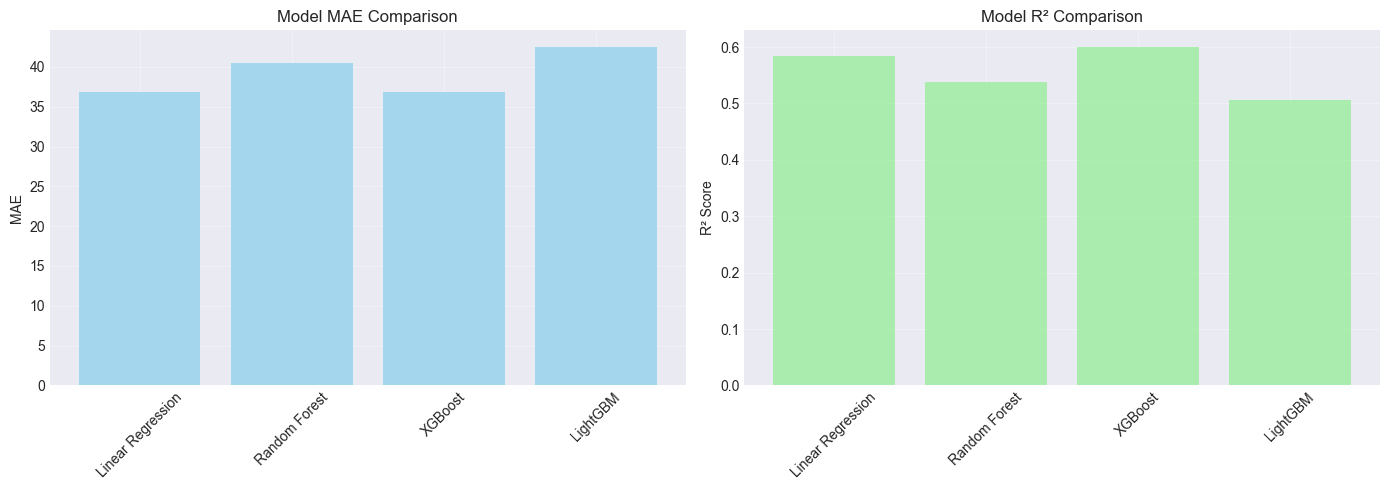

In [23]:
comparison_df = pd.DataFrame({
    'Model': ['Linear Regression', 'Random Forest', 'XGBoost', 'LightGBM'],
    'Val MAE': [val_mae_lr, val_mae_rf, val_mae_xgb, val_mae_lgb],
    'Val R²': [val_r2_lr, val_r2_rf, val_r2_xgb, val_r2_lgb]
})

print("\n" + "="*60)
print("MODEL PERFORMANCE COMPARISON")
print("="*60)
print(comparison_df.to_string(index=False))

best_mae_idx = comparison_df['Val MAE'].idxmin()
print(f"\n✓ Best Model (MAE): {comparison_df.loc[best_mae_idx, 'Model']} ({comparison_df.loc[best_mae_idx, 'Val MAE']:.4f})")

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].bar(comparison_df['Model'], comparison_df['Val MAE'], color='skyblue', alpha=0.7)
axes[0].set_ylabel('MAE')
axes[0].set_title('Model MAE Comparison')
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(True, alpha=0.3)

axes[1].bar(comparison_df['Model'], comparison_df['Val R²'], color='lightgreen', alpha=0.7)
axes[1].set_ylabel('R² Score')
axes[1].set_title('Model R² Comparison')
axes[1].tick_params(axis='x', rotation=45)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 10. Model Performance Comparison

In [24]:
print("\n" + "="*50)
print("Random Forest Regressor")
print("="*50)

rf_model = RandomForestRegressor(
    n_estimators=200,
    max_depth=20,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1
)
rf_model.fit(X_train, y_train)

y_train_pred_rf = rf_model.predict(X_train)
y_val_pred_rf = rf_model.predict(X_val)

train_mae_rf = mean_absolute_error(y_train, y_train_pred_rf)
val_mae_rf = mean_absolute_error(y_val, y_val_pred_rf)
val_r2_rf = r2_score(y_val, y_val_pred_rf)

print(f"Validation MAE: {val_mae_rf:.4f}, R²: {val_r2_rf:.4f}")

print("\n" + "="*50)
print("XGBoost Regressor")
print("="*50)

xgb_model = xgb.XGBRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)
xgb_model.fit(X_train, y_train)

y_val_pred_xgb = xgb_model.predict(X_val)
val_mae_xgb = mean_absolute_error(y_val, y_val_pred_xgb)
val_r2_xgb = r2_score(y_val, y_val_pred_xgb)

print(f"Validation MAE: {val_mae_xgb:.4f}, R²: {val_r2_xgb:.4f}")

print("\n" + "="*50)
print("LightGBM Regressor")
print("="*50)

lgb_model = lgb.LGBMRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1,
    verbose=-1
)
lgb_model.fit(X_train, y_train)

y_val_pred_lgb = lgb_model.predict(X_val)
val_mae_lgb = mean_absolute_error(y_val, y_val_pred_lgb)
val_r2_lgb = r2_score(y_val, y_val_pred_lgb)

print(f"Validation MAE: {val_mae_lgb:.4f}, R²: {val_r2_lgb:.4f}")


Random Forest Regressor
Validation MAE: 40.5422, R²: 0.5380

XGBoost Regressor
Validation MAE: 36.7846, R²: 0.5996

LightGBM Regressor
Validation MAE: 42.4668, R²: 0.5060


## 9. Random Forest and Gradient Boosting Models

In [25]:
print("="*50)
print("BASELINE MODEL: Linear Regression")
print("="*50)

lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

y_train_pred_lr = lr_model.predict(X_train)
y_val_pred_lr = lr_model.predict(X_val)

train_mae_lr = mean_absolute_error(y_train, y_train_pred_lr)
train_rmse_lr = np.sqrt(mean_squared_error(y_train, y_train_pred_lr))
train_r2_lr = r2_score(y_train, y_train_pred_lr)

val_mae_lr = mean_absolute_error(y_val, y_val_pred_lr)
val_rmse_lr = np.sqrt(mean_squared_error(y_val, y_val_pred_lr))
val_r2_lr = r2_score(y_val, y_val_pred_lr)

print(f"\nTraining Metrics:")
print(f"  MAE:  {train_mae_lr:.4f}")
print(f"  RMSE: {train_rmse_lr:.4f}")
print(f"  R²:   {train_r2_lr:.4f}")

print(f"\nValidation Metrics:")
print(f"  MAE:  {val_mae_lr:.4f}")
print(f"  RMSE: {val_rmse_lr:.4f}")
print(f"  R²:   {val_r2_lr:.4f}")

BASELINE MODEL: Linear Regression

Training Metrics:
  MAE:  29.0841
  RMSE: 43.4091
  R²:   0.7375

Validation Metrics:
  MAE:  36.8841
  RMSE: 55.8688
  R²:   0.5837


## 8. Baseline Model - Linear Regression

In [26]:
# Split data into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

print(f"Training set size: {X_train.shape[0]} samples, {X_train.shape[1]} features")
print(f"Validation set size: {X_val.shape[0]} samples, {X_val.shape[1]} features")
print(f"Test set size: {X_test_scaled.shape[0]} samples, {X_test_scaled.shape[1]} features")

print(f"\nTraining target - Mean: {y_train.mean():.2f}, Std: {y_train.std():.2f}")
print(f"Validation target - Mean: {y_val.mean():.2f}, Std: {y_val.std():.2f}")

Training set size: 2129 samples, 439 features
Validation set size: 533 samples, 439 features
Test set size: 666 samples, 439 features

Training target - Mean: 277.79, Std: 84.72
Validation target - Mean: 280.15, Std: 86.59


## 7. Train-Test Split

In [27]:
# Prepare feature matrix with engineered features
all_feature_cols = feature_cols + new_features
X = train_eng[all_feature_cols].values
y = train_eng['Tm'].values

X_test = test_eng[all_feature_cols].values

print(f"Feature matrix shape: {X.shape}")
print(f"Target vector shape: {y.shape}")
print(f"Test feature matrix shape: {X_test.shape}")

# Handle any NaN or Inf values
X = np.nan_to_num(X, nan=0.0, posinf=0.0, neginf=0.0)
X_test = np.nan_to_num(X_test, nan=0.0, posinf=0.0, neginf=0.0)

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_test_scaled = scaler.transform(X_test)

print("\nFeatures scaled using StandardScaler")
print(f"Scaled training set - Mean: {X_scaled.mean(axis=0).mean():.6f}, Std: {X_scaled.std(axis=0).mean():.6f}")
print(f"Scaled test set - Mean: {X_test_scaled.mean(axis=0).mean():.6f}, Std: {X_test_scaled.std(axis=0).mean():.6f}")

Feature matrix shape: (2662, 439)
Target vector shape: (2662,)
Test feature matrix shape: (666, 439)

Features scaled using StandardScaler
Scaled training set - Mean: -0.000000, Std: 0.799544
Scaled test set - Mean: 0.002658, Std: 0.653926


## 6. Feature Scaling and Normalization

In [28]:
def create_engineered_features(df, feature_cols):
    """Create new engineered features for group contribution analysis."""
    df_eng = df.copy()
    
    # 1. Polynomial features for top features
    for col in feature_cols[:5]:
        df_eng[f'{col}_squared'] = df_eng[col] ** 2
    
    # 2. Interaction terms
    df_eng['group_interaction_12'] = df_eng[feature_cols[0]] * df_eng[feature_cols[1]]
    df_eng['group_interaction_23'] = df_eng[feature_cols[1]] * df_eng[feature_cols[2]]
    
    # 3. Sum of all group contributions
    df_eng['total_groups'] = df_eng[feature_cols].sum(axis=1)
    
    # 4. Mean group contribution
    df_eng['mean_group'] = df_eng[feature_cols].mean(axis=1)
    
    # 5. Std of group contributions
    df_eng['std_group'] = df_eng[feature_cols].std(axis=1)
    
    # 6. Max and Min group contributions
    df_eng['max_group'] = df_eng[feature_cols].max(axis=1)
    df_eng['min_group'] = df_eng[feature_cols].min(axis=1)
    df_eng['max_min_ratio'] = df_eng['max_group'] / (df_eng['min_group'] + 1e-6)
    
    # 7. Skewness and entropy
    from scipy.stats import skew
    df_eng['skewness_groups'] = df_eng[feature_cols].apply(lambda x: skew(x), axis=1)
    
    def calculate_entropy(row):
        total = row.sum()
        if total == 0:
            return 0
        probs = row / total
        probs = probs[probs > 0]
        return -np.sum(probs * np.log(probs))
    
    df_eng['entropy_groups'] = df_eng[feature_cols].apply(calculate_entropy, axis=1)
    
    return df_eng

# Apply feature engineering
train_eng = create_engineered_features(train_df, feature_cols)
test_eng = create_engineered_features(test_df, feature_cols)

print(f"Original shape: {train_df.shape}")
print(f"After engineering: {train_eng.shape}")
print(f"\nNew features created: {train_eng.shape[1] - train_df.shape[1]}")
print(f"\nNew feature names:")
new_features = [col for col in train_eng.columns if col not in train_df.columns]
for feat in new_features:
    print(f"  - {feat}")

Original shape: (2662, 427)
After engineering: (2662, 442)

New features created: 15

New feature names:
  - Group 1_squared
  - Group 2_squared
  - Group 3_squared
  - Group 4_squared
  - Group 5_squared
  - group_interaction_12
  - group_interaction_23
  - total_groups
  - mean_group
  - std_group
  - max_group
  - min_group
  - max_min_ratio
  - skewness_groups
  - entropy_groups


## 5. Feature Engineering - Create New Features

In [29]:
# Statistical summary
print("Statistical Summary of Features:")
print(train_df[feature_cols].describe().round(3))

# Check for outliers using IQR method
print("\nFeatures with potential outliers (IQR method):")
outlier_features = []
for col in feature_cols:
    Q1 = train_df[col].quantile(0.25)
    Q3 = train_df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    outliers = train_df[(train_df[col] < lower) | (train_df[col] > upper)]
    if len(outliers) > 0:
        outlier_features.append((col, len(outliers)))

# Show top features with outliers
outlier_features.sort(key=lambda x: x[1], reverse=True)
for col, count in outlier_features[:10]:
    print(f"  {col}: {count} outliers")

Statistical Summary of Features:
        Group 1   Group 2   Group 3   Group 4   Group 5   Group 6   Group 7  \
count  2662.000  2662.000  2662.000  2662.000  2662.000  2662.000  2662.000   
mean      1.021     1.582     0.115     0.036     0.037     0.023     0.014   
std       1.354     3.738     0.426     0.208     0.206     0.164     0.119   
min       0.000     0.000     0.000     0.000     0.000     0.000     0.000   
25%       0.000     0.000     0.000     0.000     0.000     0.000     0.000   
50%       1.000     0.000     0.000     0.000     0.000     0.000     0.000   
75%       2.000     1.000     0.000     0.000     0.000     0.000     0.000   
max      16.000    42.000     6.000     3.000     2.000     2.000     2.000   

        Group 8   Group 9  Group 10  ...  Group 415  Group 416  Group 417  \
count  2662.000  2662.000  2662.000  ...   2662.000   2662.000     2662.0   
mean      0.010     0.007     0.001  ...      0.001      0.001        0.0   
std       0.117     0.09

## 4. Statistical Summary of Features

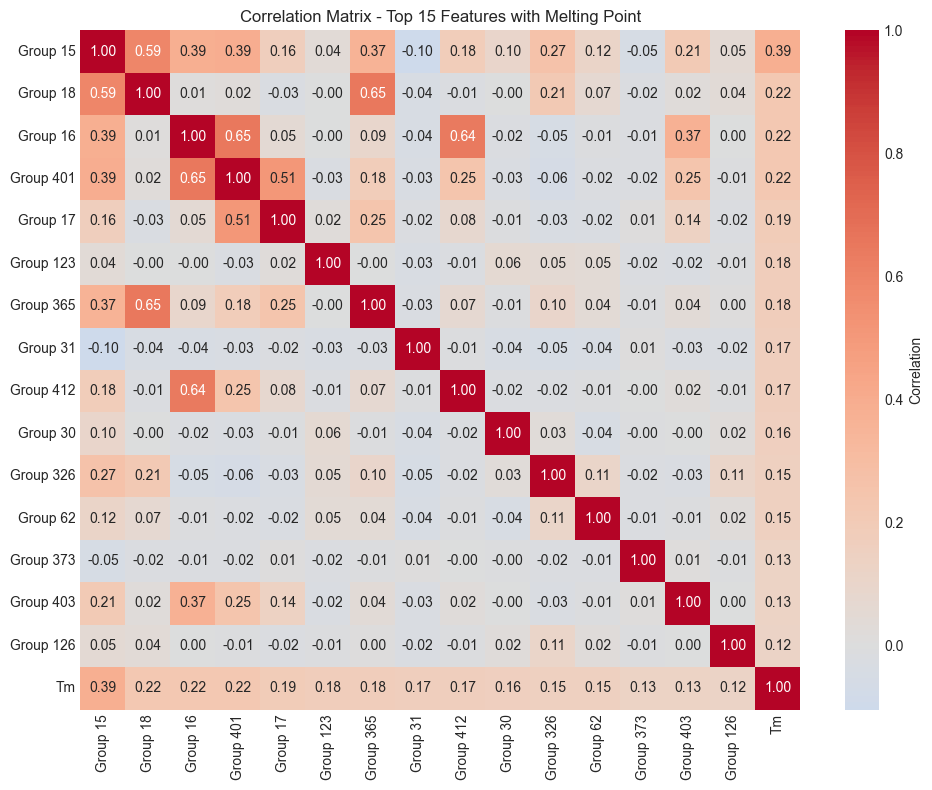

In [30]:
# Correlation heatmap (top features)
top_features = correlations[1:16].index.tolist()  # Exclude Tm itself
plt.figure(figsize=(10, 8))
sns.heatmap(train_df[top_features + ['Tm']].corr(), annot=True, fmt='.2f', 
            cmap='coolwarm', center=0, cbar_kws={'label': 'Correlation'})
plt.title('Correlation Matrix - Top 15 Features with Melting Point')
plt.tight_layout()
plt.show()

In [31]:
# Identify feature columns (exclude id, SMILES, and target)
feature_cols = [col for col in train_df.columns if col not in ['id', 'SMILES', 'Tm']]
print(f"Number of features: {len(feature_cols)}")
print(f"Feature columns: {feature_cols[:10]}...")  # Show first 10

# Correlation with target
correlations = train_df[feature_cols + ['Tm']].corr()['Tm'].sort_values(ascending=False)
print(f"\nTop 15 Features Most Correlated with Melting Point:")
print(correlations.head(15))

Number of features: 424
Feature columns: ['Group 1', 'Group 2', 'Group 3', 'Group 4', 'Group 5', 'Group 6', 'Group 7', 'Group 8', 'Group 9', 'Group 10']...

Top 15 Features Most Correlated with Melting Point:
Tm           1.000000
Group 15     0.387580
Group 18     0.223551
Group 16     0.223530
Group 401    0.222525
Group 17     0.194420
Group 123    0.179178
Group 365    0.176346
Group 31     0.171773
Group 412    0.165621
Group 30     0.162579
Group 326    0.151604
Group 62     0.150432
Group 373    0.129026
Group 403    0.125958
Name: Tm, dtype: float64


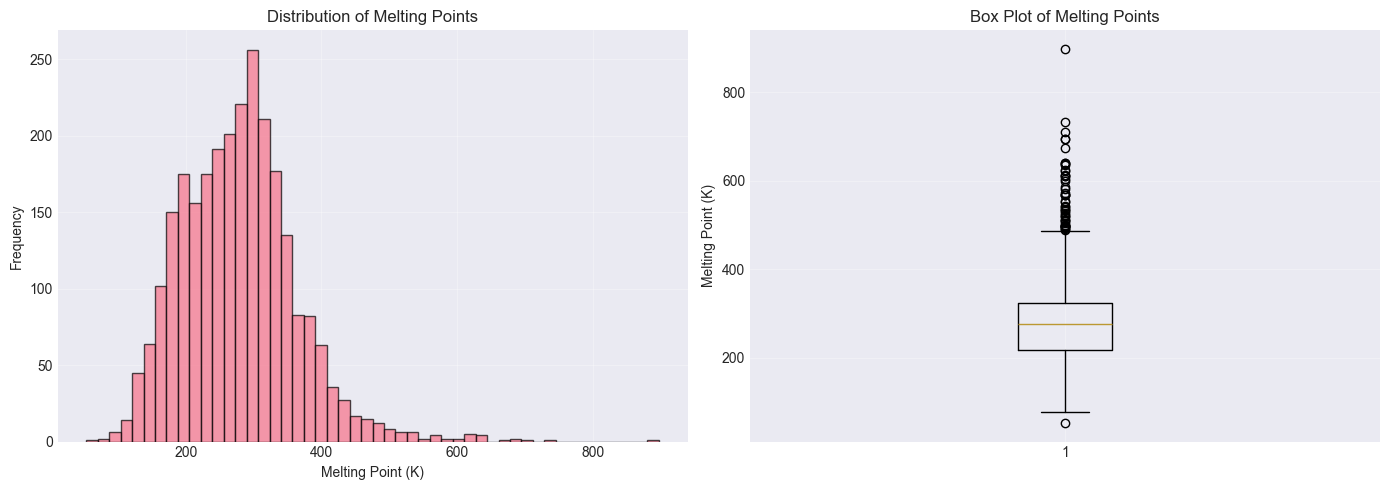

Target Variable Statistics:
count    2662.000000
mean      278.263452
std        85.117914
min        53.540000
25%       217.000000
50%       277.300000
75%       325.150000
max       897.150000
Name: Tm, dtype: float64


In [32]:
# Target variable distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram
axes[0].hist(train_df['Tm'], bins=50, edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Melting Point (K)')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of Melting Points')
axes[0].grid(True, alpha=0.3)

# Box plot
axes[1].boxplot(train_df['Tm'], vert=True)
axes[1].set_ylabel('Melting Point (K)')
axes[1].set_title('Box Plot of Melting Points')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Target Variable Statistics:")
print(train_df['Tm'].describe())

## 3. Data Visualization and Correlation Analysis

In [33]:
# Load datasets
train_df = pd.read_csv('../train.csv')
test_df = pd.read_csv('../test.csv')

print("Training Dataset Info:")
print(f"Shape: {train_df.shape}")
print(f"\nFirst few rows:")
print(train_df.head())
print(f"\nData types:")
print(train_df.dtypes)
print(f"\nMissing values:")
print(train_df.isnull().sum())

print("\n" + "="*50)
print("Test Dataset Info:")
print(f"Shape: {test_df.shape}")
print(f"\nFirst few rows:")
print(test_df.head())
print(f"\nMissing values:")
print(test_df.isnull().sum())

Training Dataset Info:
Shape: (2662, 427)

First few rows:
     id                       SMILES      Tm  Group 1  Group 2  Group 3  \
0  2175        FC1=C(F)C(F)(F)C1(F)F  213.15        0        0        0   
1  1222  c1ccc2c(c1)ccc3Nc4ccccc4c23  407.15        0        0        0   
2  2994          CCN1C(C)=Nc2ccccc12  324.15        2        1        0   
3  1704                   CC#CC(=O)O  351.15        1        0        0   
4  2526                    CCCCC(S)C  126.15        2        3        0   

   Group 4  Group 5  Group 6  Group 7  ...  Group 415  Group 416  Group 417  \
0        0        0        0        0  ...          0          0          0   
1        0        0        0        0  ...          0          0          0   
2        0        0        0        0  ...          0          0          0   
3        0        0        0        0  ...          0          0          0   
4        0        0        0        0  ...          0          0          0   

   Group 418  G

## 2. Load and Explore Dataset

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV, KFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
import xgboost as xgb
import lightgbm as lgb
import warnings
import os
import sys

warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

# Configure plotting
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

## 1. Import Required Libraries

# Melting Point Prediction - Complete ML Pipeline
## From Exploratory Analysis to Hyperparameter Tuning and Submission

This notebook implements a comprehensive machine learning pipeline for predicting melting points from group contribution features.

# Melting Point Prediction - Exploratory Data Analysis

This notebook demonstrates the exploratory data analysis and model training pipeline for melting point prediction.

In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

# Import project modules
import sys
sys.path.append('..')
from src.data_loader import MeltingPointDataLoader
from src.models import BaseModel, get_default_model_configs
from src.train import TrainingPipeline

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

%matplotlib inline

## 1. Load and Explore Data

In [36]:
# Load training data
train_df = pd.read_csv('../data/train.csv')

print(f"Training data shape: {train_df.shape}")
print(f"\nColumns: {list(train_df.columns)}")
print(f"\nFirst few rows:")
train_df.head()

FileNotFoundError: [Errno 2] No such file or directory: '../data/train.csv'

In [ ]:
# Basic statistics
train_df.describe()

## 2. Analyze Target Variable

In [ ]:
# Distribution of melting points
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(train_df['melting_point'], bins=30, edgecolor='black')
axes[0].set_xlabel('Melting Point (°C)')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of Melting Points')

axes[1].boxplot(train_df['melting_point'])
axes[1].set_ylabel('Melting Point (°C)')
axes[1].set_title('Box Plot of Melting Points')

plt.tight_layout()
plt.show()

print(f"Melting Point Statistics:")
print(f"Mean: {train_df['melting_point'].mean():.2f}°C")
print(f"Median: {train_df['melting_point'].median():.2f}°C")
print(f"Std Dev: {train_df['melting_point'].std():.2f}°C")
print(f"Min: {train_df['melting_point'].min():.2f}°C")
print(f"Max: {train_df['melting_point'].max():.2f}°C")

## 3. Analyze Features

In [ ]:
# Get feature columns
feature_cols = [col for col in train_df.columns if col not in ['id', 'melting_point']]

# Check for missing values
missing_values = train_df[feature_cols].isnull().sum()
print(f"Missing values per feature:")
print(missing_values[missing_values > 0])

if missing_values.sum() == 0:
    print("No missing values found!")

In [ ]:
# Correlation with target
correlations = train_df[feature_cols + ['melting_point']].corr()['melting_point'].drop('melting_point')
correlations = correlations.sort_values(ascending=False)

plt.figure(figsize=(10, 6))
correlations.plot(kind='bar')
plt.xlabel('Features')
plt.ylabel('Correlation with Melting Point')
plt.title('Feature Correlations with Melting Point')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

print(f"\nTop 5 positively correlated features:")
print(correlations.head())
print(f"\nTop 5 negatively correlated features:")
print(correlations.tail())

## 4. Train Models

In [ ]:
# Initialize training pipeline
pipeline = TrainingPipeline(
    train_path='../data/train.csv',
    test_path='../data/test.csv',
    model_dir='../models'
)

# Load and prepare data
X_train, X_val, y_train, y_val = pipeline.load_and_prepare_data()

In [ ]:
# Train all models
results = pipeline.train_all_models(X_train, y_train, X_val, y_val)

## 5. Compare Model Performance

In [ ]:
# Extract validation metrics
model_names = []
val_maes = []
val_rmses = []
val_r2s = []

for model_name, result in results.items():
    model_names.append(model_name)
    val_maes.append(result['val_metrics']['mae'])
    val_rmses.append(result['val_metrics']['rmse'])
    val_r2s.append(result['val_metrics']['r2'])

# Create comparison dataframe
comparison_df = pd.DataFrame({
    'Model': model_names,
    'Val MAE': val_maes,
    'Val RMSE': val_rmses,
    'Val R²': val_r2s
})

comparison_df = comparison_df.sort_values('Val MAE')
print(comparison_df.to_string(index=False))

In [ ]:
# Visualize model comparison
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

axes[0].barh(comparison_df['Model'], comparison_df['Val MAE'])
axes[0].set_xlabel('MAE')
axes[0].set_title('Validation MAE by Model')
axes[0].invert_yaxis()

axes[1].barh(comparison_df['Model'], comparison_df['Val RMSE'])
axes[1].set_xlabel('RMSE')
axes[1].set_title('Validation RMSE by Model')
axes[1].invert_yaxis()

axes[2].barh(comparison_df['Model'], comparison_df['Val R²'])
axes[2].set_xlabel('R²')
axes[2].set_title('Validation R² by Model')
axes[2].invert_yaxis()

plt.tight_layout()
plt.show()

## 6. Create Ensemble and Generate Predictions

In [ ]:
# Create ensemble model
ensemble = pipeline.create_ensemble(
    model_types=list(results.keys()),
    X_train=X_train,
    y_train=y_train,
    X_val=X_val,
    y_val=y_val
)

In [ ]:
# Generate predictions on test set
submission = pipeline.generate_predictions(
    model_name='ensemble',
    output_path='../submission.csv'
)

print(f"\nSubmission file created!")
print(f"\nFirst few predictions:")
submission.head(10)

## 7. Analyze Predictions

In [ ]:
# Plot prediction distribution
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(submission['melting_point'], bins=30, edgecolor='black', alpha=0.7)
plt.xlabel('Predicted Melting Point (°C)')
plt.ylabel('Frequency')
plt.title('Distribution of Predicted Melting Points')

plt.subplot(1, 2, 2)
plt.hist(train_df['melting_point'], bins=30, edgecolor='black', alpha=0.7, label='Training')
plt.hist(submission['melting_point'], bins=30, edgecolor='black', alpha=0.7, label='Predictions')
plt.xlabel('Melting Point (°C)')
plt.ylabel('Frequency')
plt.title('Training vs Predicted Distribution')
plt.legend()

plt.tight_layout()
plt.show()

## Summary

This notebook demonstrates:
1. Loading and exploring the melting point dataset
2. Analyzing the target variable and feature correlations
3. Training multiple machine learning models
4. Comparing model performance using MAE, RMSE, and R² metrics
5. Creating an ensemble model
6. Generating predictions for submission

The best model can be selected based on validation MAE, and the ensemble often provides improved performance.